# Pump it Up: Data Mining the Water Table

#### Analysed By :  Osafa Karim (osafa.karim@gmail.com)
#### Analysed On : 4th July 2019
#### Analysed for : Axiata Analytics - Employment Test

##### Python kernel Used

In [5]:
# kernel used
from platform import python_version
print('The version of 'python_version())

3.6.8


In [172]:
# importing the data-analysis and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
%matplotlib inline

import os
import requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

##### Download the data set for analyses from the url as is in the 
##### https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/

In [68]:
def download_data(url, file_name):
    '''
    input : 
       1. url - the url from where the file has to be downloaded
       2. file_name - the name with with the corresponding file has to be created 
    '''
    if file_name not in os.listdir():
        t0 = datetime.now()
        response = requests.get(url)
        with open(os.path.join(os.getcwd(), file_name), 'wb') as f:
            f.write(response.content)
        
        print('****** File ', file_name,', of size :',os.path.getsize(file_name)/1000000 ,' MB sucessfully downloaded in ',
             str((datetime.now()- t0).seconds),' seconds !!!!.')
    else:
        print('****** File with name ',file_name,' already exists. Please verify.')
        


In [69]:
# training-set values
url = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
file_name = 'raw_train_feature_vectors.csv'
download_data(url, file_name)

****** File  raw_train_feature_vectors.csv , of size : 20.069199  MB sucessfully downloaded in  42  seconds !!!!.


In [70]:
# training-set labels
url = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
file_name = 'raw_train_target_vectors.csv'
download_data(url, file_name)

****** File  raw_train_target_vectors.csv , of size : 1.148327  MB sucessfully downloaded in  5  seconds !!!!.


In [71]:
# testing-set values
url = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'
file_name = 'raw_test_feature_vectors.csv'
download_data(url, file_name)

****** File  raw_test_feature_vectors.csv , of size : 5.016337  MB sucessfully downloaded in  12  seconds !!!!.


#### Data Description

In [90]:
# train data-set 

train_data = pd.read_csv('raw_train_feature_vectors.csv')

In [91]:
print('There {} features and {} data-points in train-data set.'.format(train_data.shape[1],train_data.shape[0]))

There 40 features and 59400 data-points in train-data set.


In [98]:
# get the data-types of the features
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null datetime64[ns]
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null 

In [102]:
# Casting the data types of date fileds to datetime dtype
train_data['date_recorded'] = pd.to_datetime(train_data['date_recorded'])
train_data['construction_year'] = pd.to_datetime(train_data['construction_year'])

##### Check for missing data 


In [134]:
#train_data.isna().sum()
for a in train_data.columns[train_data.isna().any()].tolist():
    print(a ,' has ',train_data[train_data[a].isna()].shape[0],' missing values')

funder  has  3635  missing values
installer  has  3655  missing values
subvillage  has  371  missing values
public_meeting  has  3334  missing values
scheme_management  has  3877  missing values
scheme_name  has  28166  missing values
permit  has  3056  missing values


In [142]:
# Count of types of features
categorical = len(train_data.select_dtypes(include='object').columns)
integ = len(train_data.select_dtypes(include='int64').columns)
float_num = len(train_data.select_dtypes(include='float64').columns)
date_time = len(train_data.select_dtypes(include='datetime64[ns]').columns)


In [153]:
categorical, integ, float_num, date_time

(29, 6, 3, 2)

In [154]:
dty_list =[]

for a, b in zip([categorical, integ, float_num, date_time],['categorical', 'integ', 'float_num', 'date_time']):
    for _ in range(a):
            dty_list.append(b)
    

Text(0.5, 1.0, ' Comparison of the fetaures by dtypes')

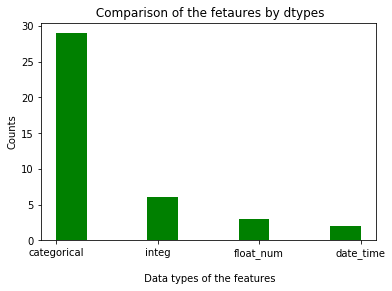

In [166]:
plt.hist(dty_list, color = 'green')
plt.xlabel('\n Data types of the features')
plt.ylabel('Counts')
plt.title(' Comparison of the fetaures by dtypes')

In [169]:
# Start dissecting the categorical features 
[ col for col in train_data.columns if train_data[col].dtypes == 'object']

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

###### Let's visualize and analyze each of the categorical features for more insights .
###### 1. Funder -  Let's visualize the top 30 Organizations who have funded the water-resources

In [244]:
fund_30 = pd.DataFrame(train_data['funder'].value_counts().head(30))

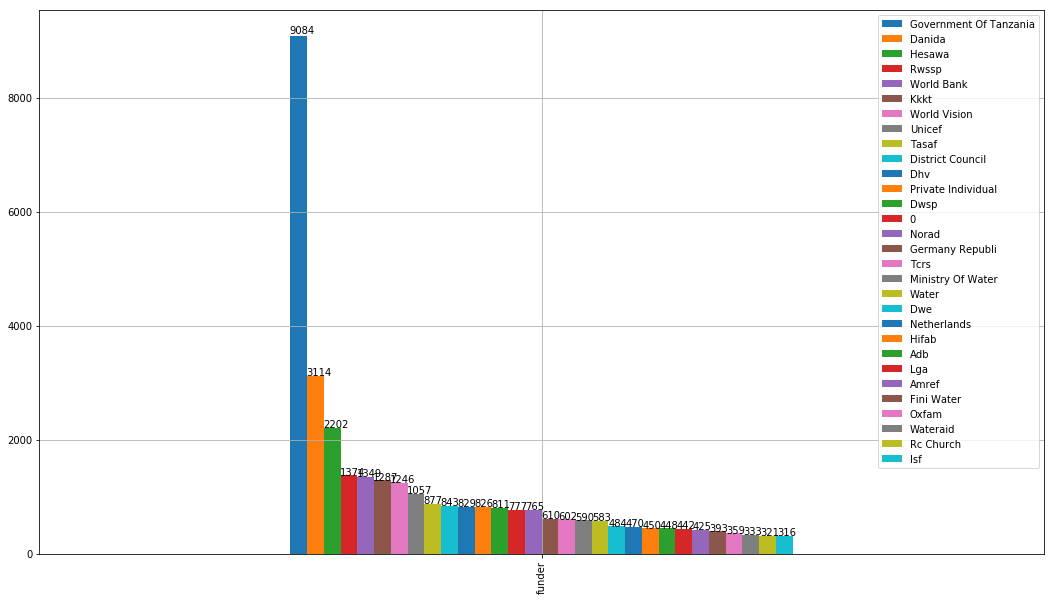

In [245]:
ax = fund_30.T.plot(kind='bar', figsize = (18, 10) , grid = True )
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### 2. Installer  -  Let's visualize top 30 installers 

In [251]:
install_30 = pd.DataFrame(train_data['installer'].value_counts().head(30))

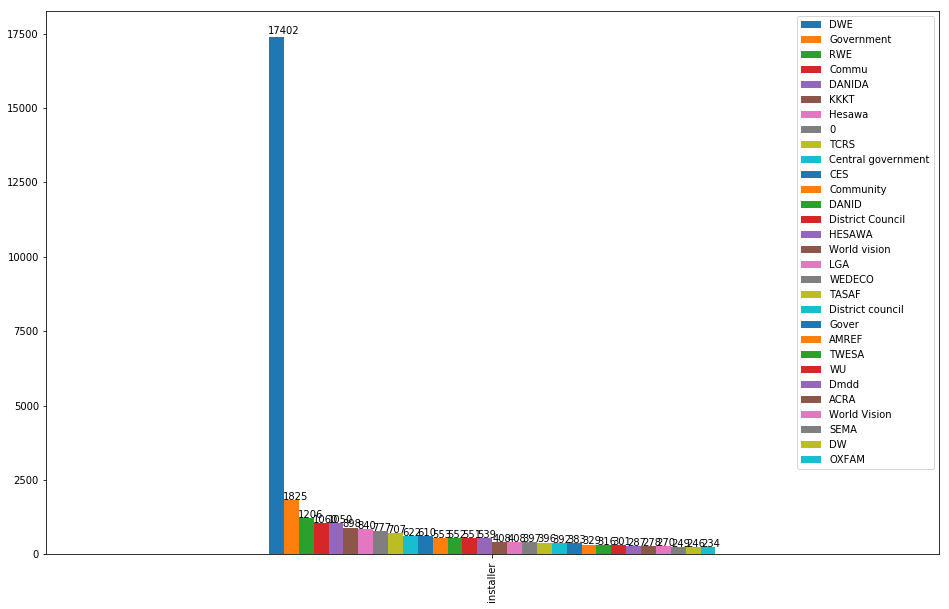

In [254]:
ax = install_30.T.plot(kind = 'bar' , figsize = (16, 10))
for p in ax.patches:
     ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

#####  *** Insight -1  ; funders and installers may or may not be same.

##### 3. wpt_name  - The name of the water points in the locality

In [257]:
wpt_30  = pd.DataFrame(train_data['wpt_name'].value_counts().head(30))

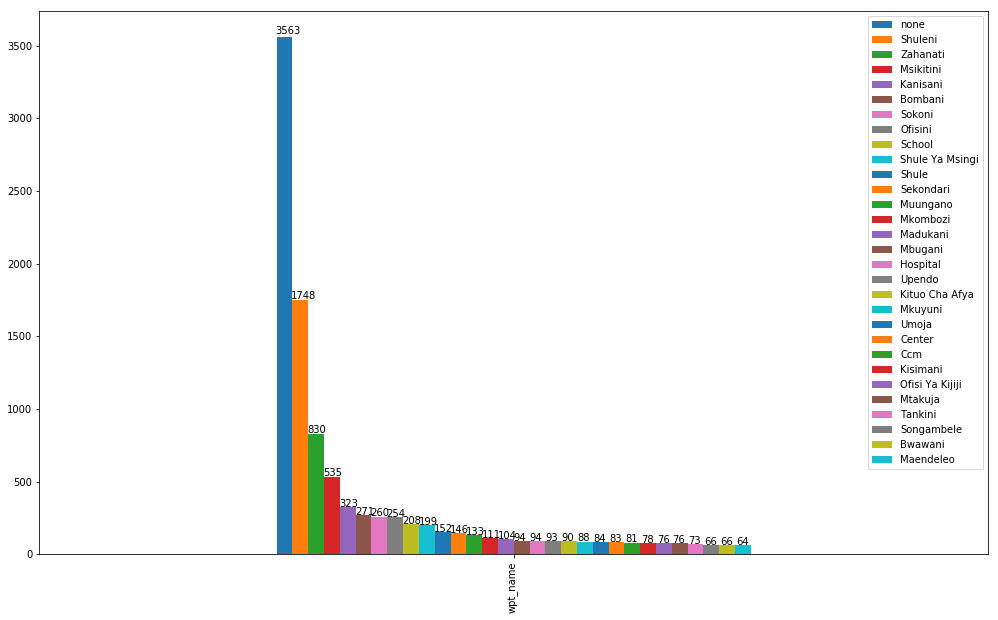

In [261]:
ax = wpt_30.T.plot(kind = 'bar' , figsize = (17, 10))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### *** Insight -2  ; A good number of locations doesn't have water_points

##### 4. basin -  Geographical Water Basin

In [265]:
len(train_data['basin'].unique())

9

In [277]:
# checking if there are missing values for basin
train_data['basin'].isna().sum()

0

#####  *** Insight -3 .  There are 9 basins from where all the waters are supplied.

In [278]:
# Let's visualize , how basins compare in terms of supplying the water
basin_df = pd.DataFrame(train_data['basin'].value_counts())

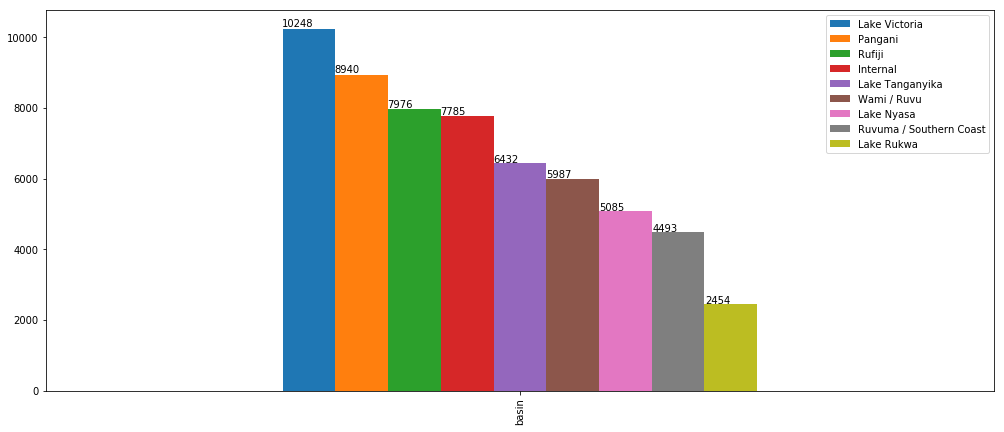

In [279]:
ax = basin_df.T.plot(kind = 'bar', figsize=(17,7))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### 5. subvillage -  Geographical Region

In [281]:
train_data['subvillage'].value_counts()

Madukani                          508
Shuleni                           506
Majengo                           502
Kati                              373
Mtakuja                           262
Sokoni                            232
M                                 187
Muungano                          172
Mbuyuni                           164
Mlimani                           152
Songambele                        147
Miembeni                          134
Msikitini                         134
1                                 132
Kibaoni                           114
Kanisani                          111
Mapinduzi                         109
I                                 109
Mjimwema                          108
Mjini                             108
Mkwajuni                          104
Mwenge                            102
Mabatini                           98
Azimio                             98
Mbugani                            95
Mission                            95
Bwawani     

In [282]:
train_data['subvillage'].isna().sum()

371

In [283]:
len(train_data['subvillage'].unique())

19288

##### At this point there is an intuition that all the features related geographical distance has a bearance in terms of proximity to main-water-bidies(basins) , which are the source of supplies for these water-points.

'Lake Victoria' = Latitude: -1° 00' 0.00" S
Longitude: 33° 00' 0.00" E

'Pangani' = Latitude: -5° 25' 30.94" S
Longitude: 38° 58' 29.03" E

'Rufiji' = Latitude: -8° 00' 0.00" S
Longitude: 39° 19' 60.00" E

'Internal'(same as ruvu) = Latitude: -6° 48' 17.99" S
Longitude: 38° 41' 59.99" E

'Lake Tanganyika' = 6.2556° S, 29.5108° E

'Wami' - Latitude: -6° 07' 60.00" S
Longitude: 38° 48' 59.99" E

'Lake Nyasa' = 11.6701° S, 34.6857° E

'Ruvuma' = 10.6879° S, 36.2631° E

'Lake Rukwa' = 8.0167° S, 32.2654° E

In [284]:
train_data['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64